<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">BE - ML</div>

# Introduction
Unmanned Aerial Vehicles (UAVs), commonly known as drones, are increasingly being deployed for applications such as surveillance, delivery, environmental monitoring, and disaster management. However, the growing reliance on UAVs also exposes them to significant **cybersecurity risks**, as malicious actors can exploit vulnerabilities in their communication and control systems. To address this challenge, **intrusion detection systems (IDSs)** leveraging machine learning have become an active area of research.

This project utilizes the **Cyber-Physical Dataset for UAVs Under Normal Operations and Cyberattacks**, developed by **Hassler, Mughal, and Ismail (2023)**. The dataset captures both **cyber and physical telemetry data** from UAVs under normal flight conditions and during four distinct types of cyberattacks:

1. **De-authentication Denial-of-Service (DoS) attack**
2. **Replay attack**
3. **False Data Injection (FDI) attack**
4. **Evil Twin attack**

The dataset is composed of two major components:

* **Cyber dataset** containing 37 features that describe network-level parameters and communication behavior.
* **Physical dataset** containing 16 features that represent UAV motion dynamics such as altitude, velocity, position, and orientation.

Each record in the dataset corresponds to either **benign (normal)** operation or one of the aforementioned **attack scenarios**, making it suitable for **binary (normal vs. malicious)** or **multi-class** classification tasks. The data were collected using a custom UAV testbed with real-time attack emulation and monitoring tools.

In this notebook, we focus on building and evaluating machine learning models to **classify UAV activities as either normal or malicious**, thereby contributing to the development of intelligent cyber-physical intrusion detection systems for UAVs.

**Reference:**
Hassler, S. C., Mughal, U. A., & Ismail, M. (2023). *Cyber-Physical Intrusion Detection System for Unmanned Aerial Vehicles*. IEEE Transactions on Intelligent Transportation Systems.
Available via github: [https://github.com/uamughal/UAVs-Dataset-Under-Normal-and-Cyberattacks](https://github.com/uamughal/UAVs-Dataset-Under-Normal-and-Cyberattacks)


# partie Colin

# partie Mohamed

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # nécessaire pour le tracé 3D
import os
import plotly.graph_objects as go
import plotly.express as px
import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [ ]:
# # === CONFIGURATION ===
# csv_path = "Dataset_T-ITS.csv"     # ton fichier d’origine
# output_dir = "Data"
# os.makedirs(output_dir, exist_ok=True)

# # === Définition des plages (1-based, inclusives) ===
# ranges = {
#     "Benign":       {"Cyber": (1, 9426),     "Physical": (9427, 13717)},
#     "DoS Attack":   {"Cyber": (13718, 25389),"Physical": (25390, 26363)},
#     "Replay Attack":{"Cyber": (26364, 38370),"Physical": (38371, 39344)},
#     "Evil Twin":    {"Cyber": (39345, 45028),"Physical": (45029, 50502)},
#     "FDI":          {"Cyber": (50503, 53976),"Physical": (53977, 54784)}
# }

# # === LECTURE SANS HEADER ===
# df_raw = pd.read_csv(csv_path, header=None)
# n = len(df_raw)
# print(f"📂 Fichier chargé ({n} lignes)\n")

# # === FONCTION DE DÉTECTION D’EN-TÊTE PAR MOT-CLÉ ===
# def is_header_line(row):
#     return row.astype(str).str.contains("class", case=False, na=False).any()

# # === EXTRACTION DES BLOCS SELON LES RANGES ===
# for attack, parts in ranges.items():
#     for part_name, (start, end) in parts.items():
#         start_idx = max(0, start - 1)
#         end_idx = min(n, end)
#         sub_df = df_raw.iloc[start_idx:end_idx].copy()

#         # Trouver la ligne d'en-tête à l'intérieur du bloc
#         header_idx = sub_df.index[sub_df.apply(is_header_line, axis=1)]
#         if len(header_idx) == 0:
#             print(f"⚠️ Aucun header trouvé dans {attack} - {part_name} ({start}-{end}), ignoré.")
#             continue

#         header_row = header_idx[0]
#         header = sub_df.loc[header_row]

#         # Supprimer les lignes avant le header
#         sub_df = sub_df.loc[header_row + 1:]
#         sub_df.columns = header
#         sub_df.reset_index(drop=True, inplace=True)

#         # === 🔹 NETTOYAGE DES COLONNES VIDES ===
#         # Supprimer colonnes entièrement vides
#         sub_df = sub_df.dropna(axis=1, how='all')

#         # Supprimer colonnes avec nom vide ou indéfini
#         sub_df = sub_df.loc[:, [str(c).strip() not in ["", "Unnamed: 0", "Unnamed: 1", "nan"] for c in sub_df.columns]]

#         # Supprimer colonnes où toutes les valeurs sont NaN ou juste des virgules vides
#         sub_df = sub_df.loc[:, sub_df.apply(lambda col: not all(str(x).strip() in ["", "nan"] for x in col), axis=0)]

#         # Calcul du nombre de features
#         valid_features = [c for c in sub_df.columns if pd.notna(c) and str(c).strip() != ""]
#         n_features = len(valid_features)

#         # Sauvegarde
#         filename = f"{attack.replace(' ', '_')}_{part_name}.csv"
#         path_out = os.path.join(output_dir, filename)
#         sub_df.to_csv(path_out, index=False)

#         # Affichage final
#         print(f"✅ {attack} ({part_name}) : {len(sub_df)} lignes, {n_features} features")

# print("\n🎯 Terminé : tous les blocs ont été extraits et nettoyés.")


/tmp/ipykernel_31497/1210916175.py:16: DtypeWarning: Columns (35,36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv(csv_path, header=None)


📂 Fichier chargé (54784 lignes)

✅ Benign (Cyber) : 9425 lignes, 38 features
✅ Benign (Physical) : 4290 lignes, 17 features
✅ DoS Attack (Cyber) : 11671 lignes, 38 features
✅ DoS Attack (Physical) : 973 lignes, 17 features
✅ Replay Attack (Cyber) : 12006 lignes, 38 features
✅ Replay Attack (Physical) : 973 lignes, 17 features
✅ Evil Twin (Cyber) : 5683 lignes, 35 features
✅ Evil Twin (Physical) : 5473 lignes, 22 features
✅ FDI (Cyber) : 3473 lignes, 35 features
✅ FDI (Physical) : 807 lignes, 32 features

🎯 Terminé : tous les blocs ont été extraits et nettoyés.


In [4]:
data_Begnin_Cyber = pd.read_csv('Data/Benign_Cyber.csv')
data_Begnin_Physical = pd.read_csv('Data/Benign_Physical.csv')
data_DoS_Cyber = pd.read_csv('Data/DoS_Attack_Cyber.csv')
data_DoS_Physical = pd.read_csv('Data/DoS_Attack_Physical.csv')
data_Replay_Cyber = pd.read_csv('Data/Replay_Attack_Cyber.csv')
data_Replay_Physical = pd.read_csv('Data/Replay_Attack_Physical.csv')
data_EvilTwin_Cyber = pd.read_csv('Data/Evil_Twin_Cyber.csv')
data_EvilTwin_Physical = pd.read_csv('Data/Evil_Twin_Physical.csv')
data_FDI_Cyber = pd.read_csv('Data/FDI_Cyber.csv')
data_FDI_Physical = pd.read_csv('Data/FDI_Physical.csv')

In [18]:
data_Begnin_Physical.head()

,timestamp_p,height,x_speed,y_speed,z_speed,pitch,roll,yaw,temperature,distance,barometer,flight_time,battery,mp_distance_x,mp_distance_y,mp_distance_z,class
0,28123.02875,80,0,0,0,0,0,0,68,84,19309,7,65,-15,-5,86,benign
1,28123.55962,80,0,0,0,0,0,0,68,84,19305,7,65,-13,-6,86,benign
2,28124.07690,80,0,0,0,0,0,0,68,83,19303,8,65,-18,-6,85,benign
3,28124.60200,80,0,0,0,-1,0,0,67,83,19307,8,65,-21,-9,84,benign
4,28125.12910,80,0,0,0,-1,0,0,67,85,19309,9,65,-24,-10,84,benign


In [3]:
data_Begnin_Physical.describe()

,timestamp_p,height,x_speed,y_speed,z_speed,pitch,roll,yaw,temperature,distance,barometer,flight_time,battery,mp_distance_x,mp_distance_y,mp_distance_z
count,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000
mean,38373.622706,71.979021,0.067599,-0.087879,0.103263,-0.546387,-0.241026,55.676923,67.177389,97.350583,20610.464103,39.074592,59.656177,-12.591142,-14.066200,67.952681
std,6880.388077,13.429245,1.315332,0.450349,0.627581,1.660456,0.776307,90.928146,2.791420,342.113961,710.914790,19.965639,23.996521,47.516717,45.159429,62.623750
min,28123.028750,-10.000000,-5.000000,-3.000000,-2.000000,-11.000000,-7.000000,-179.000000,53.000000,10.000000,18909.000000,2.000000,20.000000,-200.000000,-200.000000,-200.000000
25%,31300.990075,70.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,66.000000,79.000000,19817.000000,22.000000,40.000000,-12.000000,-14.000000,80.000000
50%,38485.998845,80.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67.000000,80.000000,21025.000000,38.000000,61.000000,-4.000000,-5.000000,82.000000
75%,43875.459452,80.000000,0.000000,0.000000,0.000000,0.000000,0.000000,178.000000,69.000000,82.000000,21231.000000,55.000000,79.000000,4.000000,4.000000,84.000000
max,54385.241520,110.000000,5.000000,3.000000,4.000000,8.000000,6.000000,179.000000,74.000000,6553.000000,21356.000000,95.000000,100.000000,68.000000,49.000000,122.000000


### Physical Data exploration

In [46]:
import plotly.graph_objects as go

def plot_3d_flight_path_animated(df, title="Animation 3D — Trajectoire dans le temps", frame_duration=400):
    """
    Crée une animation 3D de la trajectoire (mp_distance_x, mp_distance_y, mp_distance_z)
    évoluant dans le temps selon 'timestamp_p', sans température.
    
    Paramètres :
        df : DataFrame contenant les colonnes ['timestamp_p','mp_distance_x','mp_distance_y','mp_distance_z']
        title : titre du graphique
        frame_duration : durée (ms) de chaque frame — plus grand = animation plus lente
    """

    required_cols = ["timestamp_p", "mp_distance_x", "mp_distance_y", "mp_distance_z"]
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"❌ Colonne manquante : {col}")

    df_sorted = df.sort_values("timestamp_p").reset_index(drop=True)
    n_frames = min(100, len(df_sorted))
    step = max(1, len(df_sorted) // n_frames)

    fig = go.Figure(
        data=[
            go.Scatter3d(
                x=[df_sorted["mp_distance_x"].iloc[0]],
                y=[df_sorted["mp_distance_y"].iloc[0]],
                z=[df_sorted["mp_distance_z"].iloc[0]],
                mode="lines+markers",
                line=dict(color="blue", width=4),
                marker=dict(size=4, color="blue"),
                name="Trajectoire"
            )
        ],
        layout=go.Layout(
            title=title,
            scene=dict(
                xaxis_title="mp_distance_x",
                yaxis_title="mp_distance_y",
                zaxis_title="mp_distance_z",
                aspectmode="cube"
            ),
            template="plotly_white",
            width=950,
            height=800,
            updatemenus=[{
                "buttons": [
                    {
                        # ⏬ vitesse ajustée ici
                        "args": [None, {"frame": {"duration": frame_duration, "redraw": True},
                                        "fromcurrent": True, "mode": "immediate"}],
                        "label": "▶️ Play",
                        "method": "animate"
                    },
                    {
                        "args": [[None], {"frame": {"duration": 0, "redraw": True},
                                          "mode": "immediate"}],
                        "label": "⏸️ Pause",
                        "method": "animate"
                    }
                ],
                "direction": "left",
                "pad": {"r": 10, "t": 85},
                "showactive": False,
                "type": "buttons",
                "x": 0.1,
                "xanchor": "right",
                "y": 0,
                "yanchor": "top"
            }]
        ),
        frames=[
            go.Frame(
                data=[
                    go.Scatter3d(
                        x=df_sorted["mp_distance_x"].iloc[:k],
                        y=df_sorted["mp_distance_y"].iloc[:k],
                        z=df_sorted["mp_distance_z"].iloc[:k],
                        mode="lines+markers",
                        line=dict(color="blue", width=4),
                        marker=dict(size=3, color="blue")
                    )
                ],
                name=f"Frame {k}",
                traces=[0],
                layout=go.Layout(
                    title=f"{title} — t = {df_sorted['timestamp_p'].iloc[k]}"
                )
            )
            for k in range(1, len(df_sorted), step)
        ]
    )

    fig.show()


In [47]:
plot_3d_flight_path_animated(
    data_Begnin_Physical, 
    title="Animation 3D — Données physiques bénignes"
)

plot_3d_flight_path_animated(
    data_DoS_Physical, 
    title="Animation 3D — Données physiques DoS Attack"
)
plot_3d_flight_path_animated(
    data_Replay_Physical, 
    title="Animation 3D — Données physiques Replay Attack"
)

In [5]:
def plot_flight_distance_temperature_continuous(df, title="Courbe continue — timestamp_p vs distance"):
    """
    Trace une ligne continue avec des points colorés par température.
    """
    required_cols = ["timestamp_p", "distance", "temperature"]
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"❌ Colonne manquante dans le DataFrame : {col}")

    df_sorted = df.sort_values(by="timestamp_p")

    fig = go.Figure()

    # Ligne grise en arrière-plan
    fig.add_trace(go.Scatter(
        x=df_sorted["timestamp_p"],
        y=df_sorted["distance"],
        mode="lines",
        line=dict(color="lightgray", width=1.5),
        name="Trajectoire"
    ))

    # Points colorés par température
    fig.add_trace(go.Scatter(
        x=df_sorted["timestamp_p"],
        y=df_sorted["distance"],
        mode="markers",
        marker=dict(
            color=df_sorted["temperature"],
            colorscale="Plasma",
            size=6,
            colorbar=dict(title="Température"),
            showscale=True
        ),
        name="Température"
    ))

    fig.update_layout(
        title=title,
        xaxis_title="timestamp_p",
        yaxis_title="distance",
        template="plotly_white",
        width=950,
        height=700
    )

    fig.show()



# Exemple d'utilisation :
plot_flight_distance_temperature_continuous(data_Begnin_Physical, 
    title="Courbe continue — Données physiques bénignes")
plot_flight_distance_temperature_continuous(data_DoS_Physical, 
    title="Courbe continue — Données physiques DoS Attack")
plot_flight_distance_temperature_continuous(data_Replay_Physical, 
    title="Courbe continue — Données physiques Replay Attack")


### Cyber Data exploration

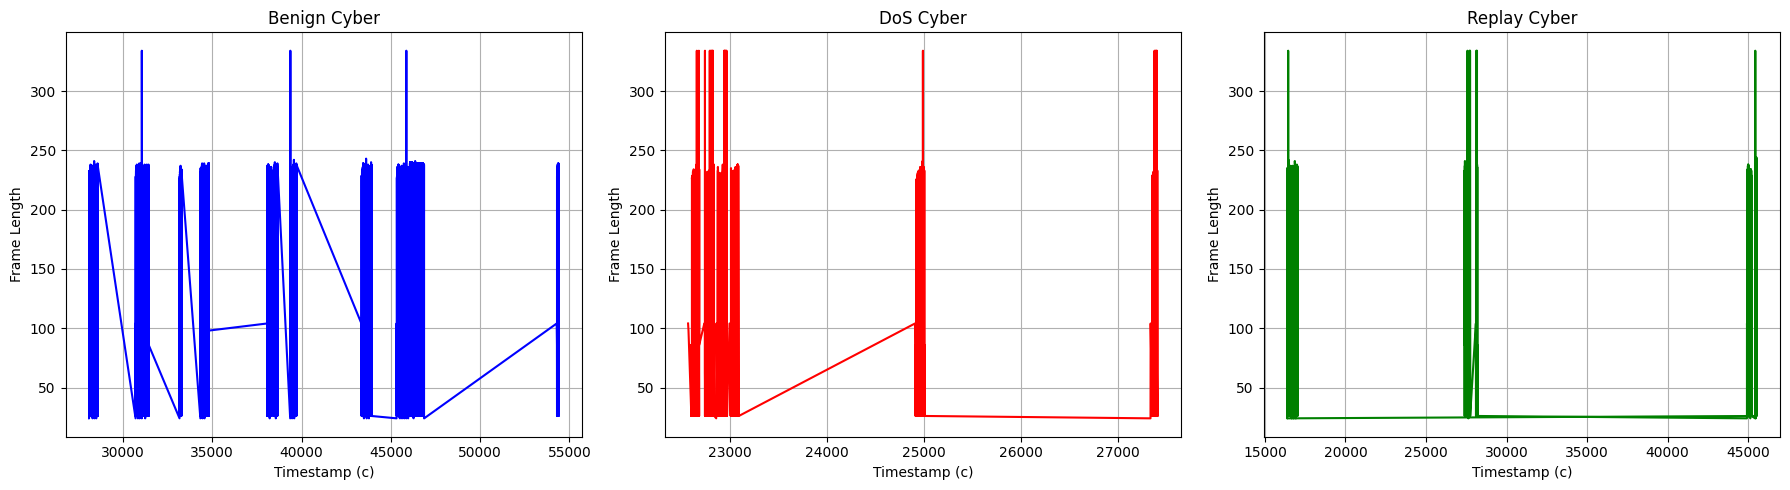

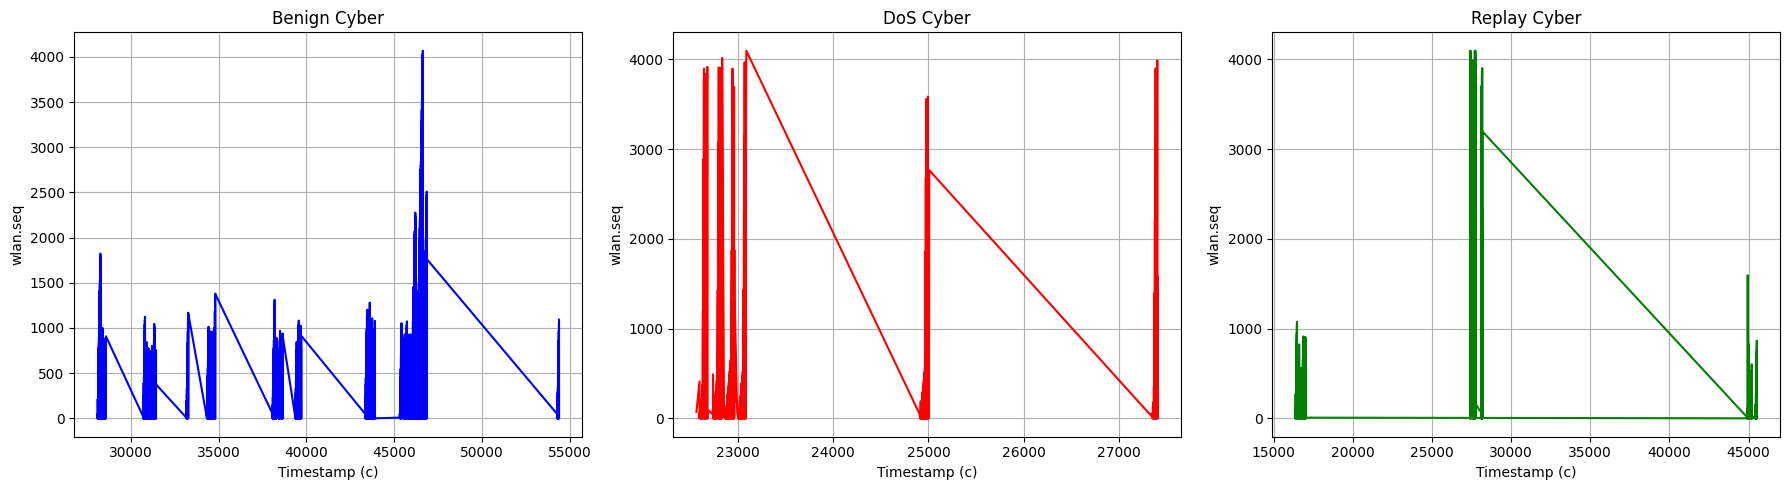

In [13]:
# Suppose que tu as déjà chargé tes trois DataFrames :
# data_Benign_Cyber, data_DoS_Cyber, data_Replay_Cyber
# et qu'ils contiennent les colonnes 'timestamp_c' et 'frame.len'

plt.figure(figsize=(18, 5))

# --- Plot 1 : Benign ---
plt.subplot(1, 3, 1)
plt.plot(data_Begnin_Cyber['timestamp_c'], data_Begnin_Cyber['frame.len'], color='blue')
plt.title('Benign Cyber')
plt.xlabel('Timestamp (c)')
plt.ylabel('Frame Length')
plt.grid(True)

# --- Plot 2 : DoS ---
plt.subplot(1, 3, 2)
plt.plot(data_DoS_Cyber['timestamp_c'], data_DoS_Cyber['frame.len'], color='red')
plt.title('DoS Cyber')
plt.xlabel('Timestamp (c)')
plt.ylabel('Frame Length')
plt.grid(True)

# --- Plot 3 : Replay ---
plt.subplot(1, 3, 3)
plt.plot(data_Replay_Cyber['timestamp_c'], data_Replay_Cyber['frame.len'], color='green')
plt.title('Replay Cyber')
plt.xlabel('Timestamp (c)')
plt.ylabel('Frame Length')
plt.grid(True)

plt.tight_layout()
plt.show()
plt.figure(figsize=(18, 5))
# Suppose que tu as déjà chargé tes trois DataFrames :
# data_Benign_Cyber, data_DoS_Cyber, data_Replay_Cyber
# et qu'ils contiennent les colonnes 'timestamp_c' et 'wlan.seq'
# --- Plot 1 : Benign ---
plt.subplot(1, 3, 1)
plt.plot(data_Begnin_Cyber['timestamp_c'], data_Begnin_Cyber['wlan.seq'], color='blue')
plt.title('Benign Cyber')
plt.xlabel('Timestamp (c)')
plt.ylabel('wlan.seq')
plt.grid(True)

# --- Plot 2 : DoS ---
plt.subplot(1, 3, 2)
plt.plot(data_DoS_Cyber['timestamp_c'], data_DoS_Cyber['wlan.seq'], color='red')
plt.title('DoS Cyber')
plt.xlabel('Timestamp (c)')
plt.ylabel('wlan.seq')
plt.grid(True)

# --- Plot 3 : Replay ---
plt.subplot(1, 3, 3)
plt.plot(data_Replay_Cyber['timestamp_c'], data_Replay_Cyber['wlan.seq'], color='green')
plt.title('Replay Cyber')
plt.xlabel('Timestamp (c)')
plt.ylabel('wlan.seq')
plt.grid(True)

plt.tight_layout()
plt.show()


### Physical Data 

In [ ]:
# # === CONFIGURATION ===
# # Chemin vers le dossier contenant les fichiers physiques
# input_dir = "Data"       # dossier où tu as sauvegardé les CSV
# output_file = "Data/Merged_Physical.csv"

# # Liste précise des fichiers à fusionner
# files_to_merge = [
#     os.path.join(input_dir, "Benign_Physical.csv"),
#     os.path.join(input_dir, "DoS_Attack_Physical.csv"),
#     os.path.join(input_dir, "Replay_Attack_Physical.csv")
# ]

# # === Vérification existence ===
# for f in files_to_merge:
#     if not os.path.exists(f):
#         raise FileNotFoundError(f"❌ Fichier introuvable : {f}")

# # === Lecture et nettoyage ===
# dfs = []
# for i, f in enumerate(files_to_merge):
#     df = pd.read_csv(f)
    
#     # Supprimer toute ligne contenant "class" ou "timestamp" dans la première colonne (résidus d'en-têtes)
#     df = df[~df.iloc[:, 0].astype(str).str.contains("class|timestamp", case=False, na=False)]
    
#     # Garder l'en-tête uniquement pour le premier fichier
#     if i == 0:
#         dfs.append(df)
#     else:
#         # Vérifier cohérence colonnes
#         df.columns = dfs[0].columns
#         dfs.append(df)

# # === Fusion verticale ===
# merged_df = pd.concat(dfs, ignore_index=True)

# # === Nettoyage final ===
# merged_df = merged_df.dropna(how="all")  # supprimer lignes vides
# merged_df.reset_index(drop=True, inplace=True)

# # === Sauvegarde ===
# merged_df.to_csv(output_file, index=False)
# print(f"✅ Fichiers fusionnés -> {output_file}")
# print(f"Total : {len(merged_df)} lignes, {len(merged_df.columns)} colonnes")


✅ Fichiers fusionnés -> Data/Merged_Physical.csv
Total : 6236 lignes, 17 colonnes


###  Cyber Data 

In [ ]:
# # === CONFIGURATION ===
# input_dir = "Data"          # dossier où se trouvent tes fichiers .csv
# output_file = "Data/Merged_Cyber.csv"

# # === Fichiers à fusionner ===
# files_to_merge = [
#     os.path.join(input_dir, "Benign_Cyber.csv"),
#     os.path.join(input_dir, "DoS_Attack_Cyber.csv"),
#     os.path.join(input_dir, "Replay_Attack_Cyber.csv")
# ]

# # === Vérification existence ===
# for f in files_to_merge:
#     if not os.path.exists(f):
#         raise FileNotFoundError(f"❌ Fichier introuvable : {f}")

# # === Lecture + Nettoyage ===
# dfs = []
# for i, f in enumerate(files_to_merge):
#     df = pd.read_csv(f)
    
#     # Supprimer toute ligne contenant "class" ou "timestamp" dans la première colonne (cas d'en-tête répété)
#     df = df[~df.iloc[:, 0].astype(str).str.contains("class|timestamp", case=False, na=False)]
    
#     # Harmoniser les colonnes avec le premier fichier
#     if i == 0:
#         dfs.append(df)
#     else:
#         df.columns = dfs[0].columns  # Assure la même structure
#         dfs.append(df)

# # === Fusionner verticalement ===
# merged_df = pd.concat(dfs, ignore_index=True)
# merged_df = merged_df.dropna(how="all")   # Supprime lignes vides
# merged_df.reset_index(drop=True, inplace=True)

# # === Sauvegarde ===
# merged_df.to_csv(output_file, index=False)
# print(f"✅ Fichiers fusionnés -> {output_file}")
# print(f"Total : {len(merged_df)} lignes, {len(merged_df.columns)} colonnes")


✅ Fichiers fusionnés -> Data/Merged_Cyber.csv
Total : 33102 lignes, 38 colonnes


### Chargement des données

In [10]:
# === Chargement des données ===
data_Physical = pd.read_csv('Data/Merged_Physical.csv')
X_physical = data_Physical.drop(columns=['class','timestamp_p','barometer'])
y_physical = data_Physical['class']

data_Cyber = pd.read_csv('Data/Merged_Cyber.csv')
X_cyber = data_Cyber.drop(columns=['class','timestamp_c','frame.number'])
y_cyber = data_Cyber['class']

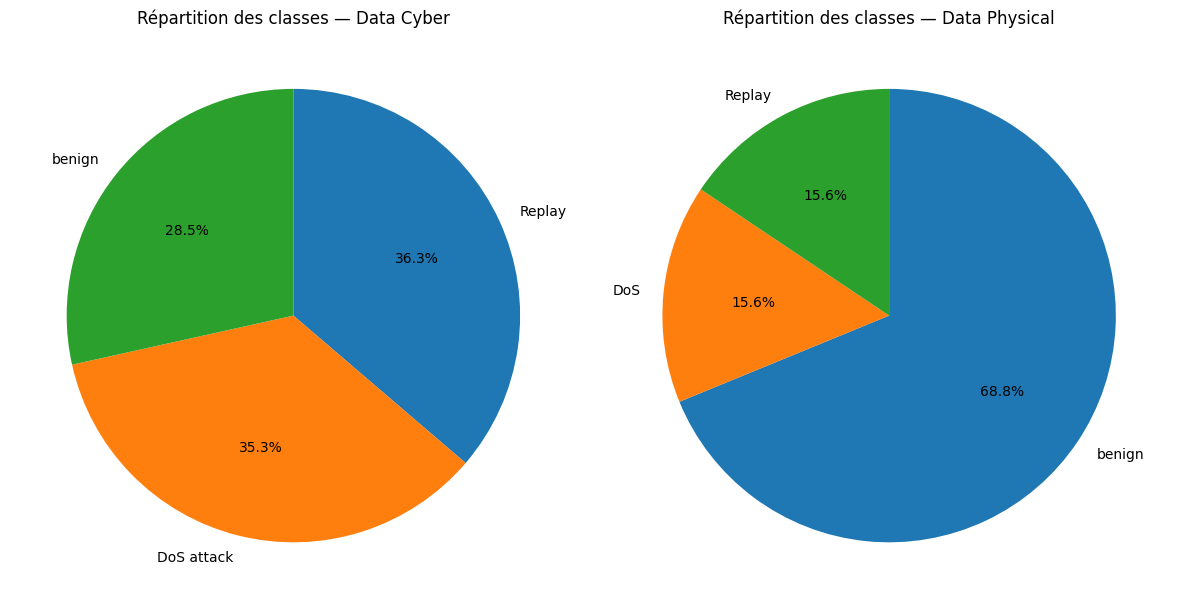

In [6]:
# === Vérification des colonnes ===
for name, df in [("Cyber", data_Cyber), ("Physical", data_Physical)]:
    if "class" not in df.columns:
        raise KeyError(f"❌ La colonne 'class' est introuvable dans {name}")

# === Comptage des classes ===
class_counts_cyber = data_Cyber["class"].value_counts()
class_counts_physical = data_Physical["class"].value_counts()

# === Création des sous-graphiques ===
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# --- Pie chart Cyber ---
axes[0].pie(
    class_counts_cyber,
    labels=class_counts_cyber.index,
    autopct="%1.1f%%",
    startangle=90,
    counterclock=False
)
axes[0].set_title("Répartition des classes — Data Cyber")

# --- Pie chart Physical ---
axes[1].pie(
    class_counts_physical,
    labels=class_counts_physical.index,
    autopct="%1.1f%%",
    startangle=90,
    counterclock=False
)
axes[1].set_title("Répartition des classes — Data Physical")

# === Ajustements ===
plt.tight_layout()
plt.show()


### Classification


=== 🧠 Rapport de classification ===
              precision    recall  f1-score   support

  DoS attack       0.57      0.83      0.68      3501
      Replay       0.77      0.22      0.34      3602
      benign       0.73      0.98      0.84      2828

    accuracy                           0.65      9931
   macro avg       0.69      0.68      0.62      9931
weighted avg       0.69      0.65      0.60      9931


=== 📊 Matrice de confusion ===
[[2919  214  368]
 [2171  798  633]
 [  44   25 2759]]


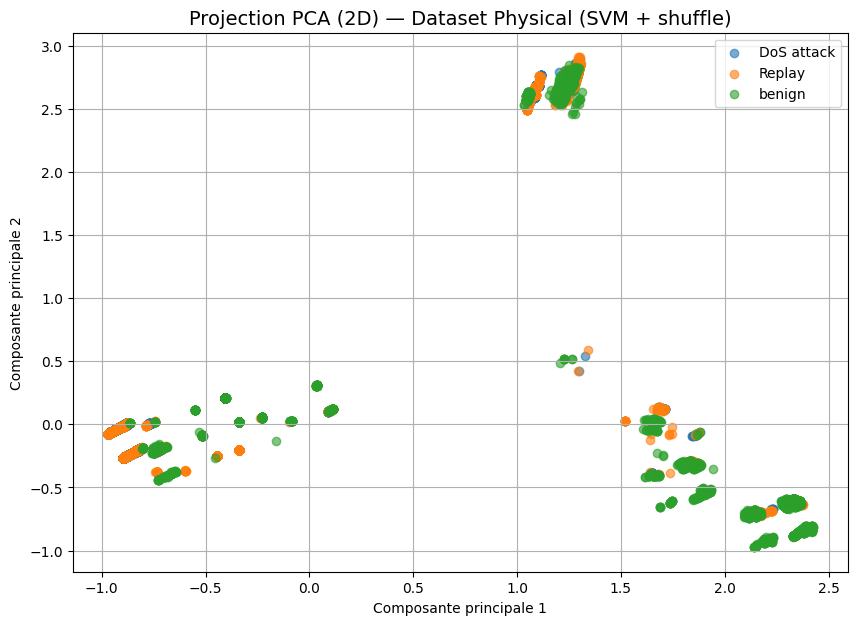

In [8]:
# === Choisir le dataset à utiliser ===
# X = X_physical
# y = y_physical
X = X_cyber
y = y_cyber

# === 0. Mélange aléatoire (shuffle) ===
X, y = shuffle(X, y, random_state=42)

# === 1. Normalisation ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# === 2. Découpage train/test ===
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# === 3. Entraînement du SVM ===
svm = SVC(kernel='rbf', gamma='scale',degree=5)
svm.fit(X_train, y_train)

# === 4. Évaluation ===
y_pred = svm.predict(X_test)
print("\n=== 🧠 Rapport de classification ===")
print(classification_report(y_test, y_pred))
print("\n=== 📊 Matrice de confusion ===")
print(confusion_matrix(y_test, y_pred))

# === 5. Réduction de dimension (PCA à 2 composantes) ===
pca = PCA(n_components=16)
X_pca = pca.fit_transform(X_scaled)

# === 6. Visualisation ===
plt.figure(figsize=(10, 7))
classes = np.unique(y)

for c in classes:
    plt.scatter(X_pca[y == c, 0], X_pca[y == c, 1], label=c, alpha=0.6)

plt.title("Projection PCA (2D) — Dataset Physical (SVM + shuffle)", fontsize=14)
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.legend()
plt.grid(True)
plt.show()


### Random Forest avec Merged_Physical


=== 🧠 Rapport de classification ===
              precision    recall  f1-score   support

         DoS       0.96      0.99      0.98       243
      Replay       1.00      0.88      0.94       243
      benign       0.97      0.99      0.98      1073

    accuracy                           0.98      1559
   macro avg       0.98      0.96      0.97      1559
weighted avg       0.98      0.98      0.98      1559


=== 📊 Matrice de confusion ===
[[ 241    0    2]
 [   2  215   26]
 [   7    1 1065]]


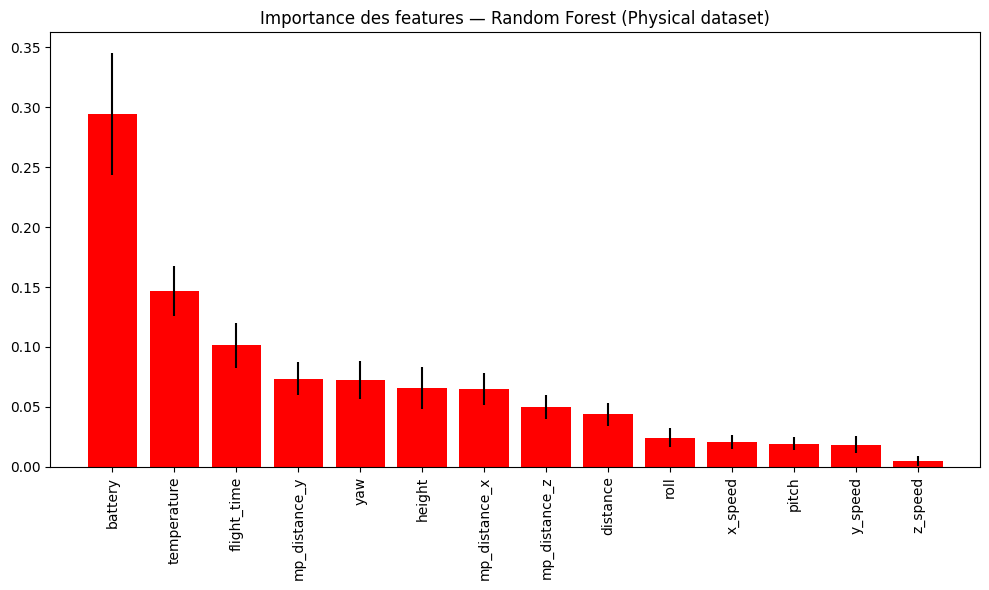


=== 🔝 Top 10 features importantes ===
1. battery (0.2942)
2. temperature (0.1467)
3. flight_time (0.1014)
4. mp_distance_y (0.0734)
5. yaw (0.0728)
6. height (0.0657)
7. mp_distance_x (0.0650)
8. mp_distance_z (0.0496)
9. distance (0.0438)
10. roll (0.0241)


In [15]:
# === Chargement des données ===
X = data_Physical.drop(columns=['class','timestamp_p','barometer'])
y = data_Physical['class']
X, y = shuffle(X, y, random_state=42)
# === Normalisation ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


# Initialisation du scaler Min-Max
scaler = MinMaxScaler()

# Application de la normalisation
X_scaled = scaler.fit_transform(X)

# === Découpage train/test ===
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, stratify=y
)

# === Entraînement Random Forest ===
rf = RandomForestClassifier(
    n_estimators=200, criterion='entropy', random_state=42
)
rf.fit(X_train, y_train)

# === Évaluation ===
print("\n=== 🧠 Rapport de classification ===")
print(classification_report(y_test, rf.predict(X_test)))
print("\n=== 📊 Matrice de confusion ===")
print(confusion_matrix(y_test, rf.predict(X_test)))

# === Importance des features ===
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Importance des features — Random Forest (Physical dataset)")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

# === Afficher les features les plus importantes ===
print("\n=== 🔝 Top 10 features importantes ===")
for i in range(min(10, len(indices))):
    print(f"{i+1}. {X.columns[indices[i]]} ({importances[indices[i]]:.4f})")


### Random Forest with Merged_Cyber


=== 🧠 Rapport de classification ===
              precision    recall  f1-score   support

  DoS attack       0.67      0.69      0.68      2918
      Replay       0.68      0.62      0.65      3002
      benign       0.85      0.90      0.87      2356

    accuracy                           0.72      8276
   macro avg       0.73      0.74      0.73      8276
weighted avg       0.72      0.72      0.72      8276


=== 📊 Matrice de confusion ===
[[2022  737  159]
 [ 920 1859  223]
 [  84  158 2114]]


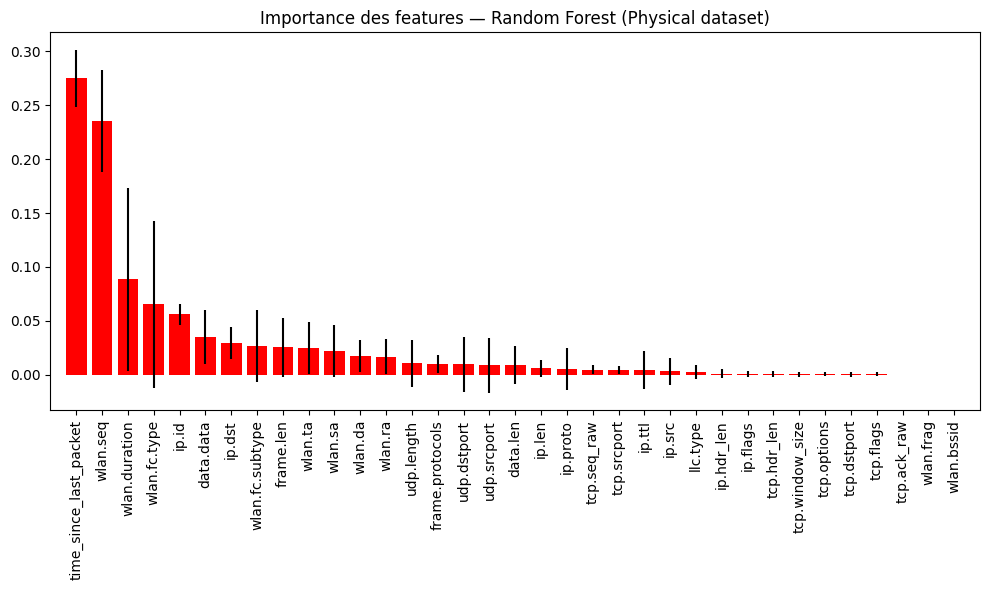


=== 🔝 Top 16 features importantes ===
1. time_since_last_packet (0.2750)
2. wlan.seq (0.2354)
3. wlan.duration (0.0886)
4. wlan.fc.type (0.0652)
5. ip.id (0.0560)
6. data.data (0.0348)
7. ip.dst (0.0296)
8. wlan.fc.subtype (0.0268)
9. frame.len (0.0255)
10. wlan.ta (0.0246)
11. wlan.sa (0.0220)
12. wlan.da (0.0175)
13. wlan.ra (0.0167)
14. udp.length (0.0107)
15. frame.protocols (0.0098)
16. udp.dstport (0.0096)


In [21]:
# === Chargement des données ===
X = data_Cyber.drop(columns=['class','timestamp_c','frame.number'])
y = data_Cyber['class']
X, y = shuffle(X, y, random_state=42)

# Initialisation du scaler Min-Max
# scaler = MinMaxScaler()
scaler= StandardScaler()
# Application de la normalisation
X_scaled = scaler.fit_transform(X)
# X_scaled = X

# === Découpage train/test ===
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, stratify=y
)

# === Entraînement Random Forest ===
rf = RandomForestClassifier(
    n_estimators=200, criterion='entropy', random_state=42
)
rf.fit(X_train, y_train)

# === Évaluation ===
print("\n=== 🧠 Rapport de classification ===")
print(classification_report(y_test, rf.predict(X_test)))
print("\n=== 📊 Matrice de confusion ===")
print(confusion_matrix(y_test, rf.predict(X_test)))

# === Importance des features ===
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Importance des features — Random Forest (Physical dataset)")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

# === Afficher les features les plus importantes ===
print("\n=== 🔝 Top 16 features importantes ===")
for i in range(min(16, len(indices))):
    print(f"{i+1}. {X.columns[indices[i]]} ({importances[indices[i]]:.4f})")


### Anomaly detection part

In [9]:
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

In [26]:
# === Données utilisées ===
print(f"✅ Données d’entrée : {X_physical.shape[0]} lignes, {X_physical.shape[1]} colonnes")

# === Normalisation ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_physical)

# === Initialisation du modèle Isolation Forest ===
iso_forest = IsolationForest(
    n_estimators=200,     # nombre d’arbres (100 par défaut)
    contamination=0.05,   # proportion estimée d’anomalies (à ajuster selon ton dataset)
    random_state=42
)

# === Entraînement ===
iso_forest.fit(X_scaled)

# === Prédictions ===
anomaly_labels = iso_forest.predict(X_scaled)     # -1 = anomalie, 1 = normal
anomaly_scores = iso_forest.decision_function(X_scaled)  # plus petit = plus anormal

# === Ajout des résultats au DataFrame original ===
data_Physical["anomaly_label"] = anomaly_labels
data_Physical["anomaly_score"] = anomaly_scores

# === Résumé ===
count_normal = np.sum(anomaly_labels == 1)
count_anomaly = np.sum(anomaly_labels == -1)
print(f"🔹 Normaux   : {count_normal}")
print(f"🔹 Anomalies : {count_anomaly}")


✅ Données d’entrée : 6236 lignes, 14 colonnes
🔹 Normaux   : 5924
🔹 Anomalies : 312


In [27]:
def plotAnomalyScore2D_existing(df, x_col, y_col, score_col):
    plt.figure(figsize=(7,6))
    sc = plt.scatter(df[x_col], df[y_col], c=-df[score_col], cmap='Reds', s=20)
    plt.colorbar(sc, label='Anomaly score (plus foncé = plus anormal)')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f"Isolation Forest — {x_col} vs {y_col}")
    plt.show()


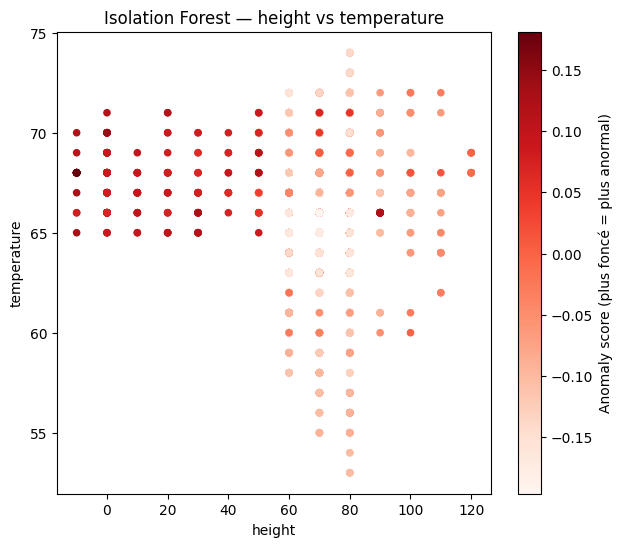

In [29]:
plotAnomalyScore2D_existing(data_Physical, 'height', 'temperature', 'anomaly_score')



In [ ]:
# === Données utilisées ===
print(f"✅ Données d’entrée : {X_cyber.shape[0]} lignes, {X_cyber.shape[1]} colonnes")

# === Normalisation ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cyber)

# === Initialisation du modèle Isolation Forest ===
iso_forest = IsolationForest(
    n_estimators=200,     # nombre d’arbres (100 par défaut)
    contamination=0.4,   # proportion estimée d’anomalies (à ajuster selon ton dataset)
    random_state=42
)

# === Entraînement ===
iso_forest.fit(X_scaled)

# === Prédictions ===
anomaly_labels = iso_forest.predict(X_scaled)     # -1 = anomalie, 1 = normal
anomaly_scores = iso_forest.decision_function(X_scaled)  # plus petit = plus anormal

# === Ajout des résultats au DataFrame original ===
data_Cyber["anomaly_label"] = anomaly_labels
data_Cyber["anomaly_score"] = anomaly_scores

# === Résumé ===
count_normal = np.sum(anomaly_labels == 1)
count_anomaly = np.sum(anomaly_labels == -1)
print(f"🔹 Normaux   : {count_normal}")
print(f"🔹 Anomalies : {count_anomaly}")


✅ Données d’entrée : 33102 lignes, 35 colonnes
🔹 Normaux   : 29800
🔹 Anomalies : 3302


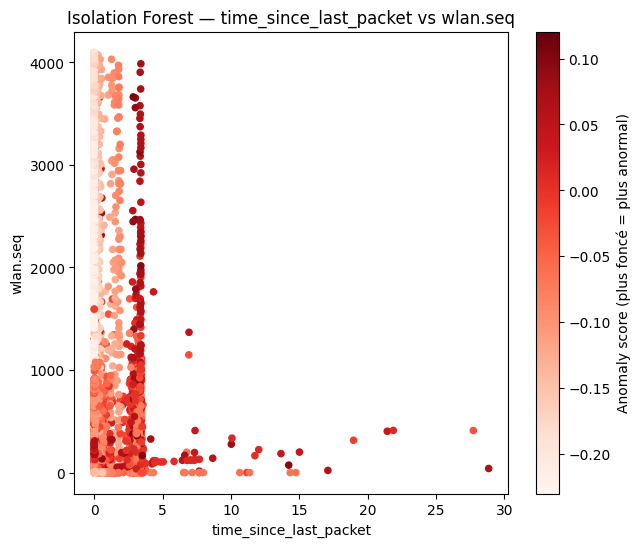

In [32]:
plotAnomalyScore2D_existing(data_Cyber, 'time_since_last_packet', 'wlan.seq', 'anomaly_score')
